In [38]:
#Import packages used in lottery

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter
sns.set_theme('notebook')

In [39]:
#Set variables used in multiple sections

# this is the google response sheet from the form
Year = "2025"
Semester = "Fall"
sep = '\\'
filename = Year + " " + Semester + " Neuroscience Seminar Registration Request Form (Responses).xlsx"
print(Year + sep + filename) #This is the file (and folder location) of request form responses

lottery_courses = ['1440','1930K'] #MUST BE IN SAME ORDER AS PRESENTED ON FORM

2025\2025 Fall Neuroscience Seminar Registration Request Form (Responses).xlsx


## SECTION 1: VERIFY PREREQUISITES

### 1A: Identify required prerequities for each student based on requested courses

In [40]:
#Generate list of courses requested by each student from the response sheet


#Load list of all NEUR small courses and their prerequisites
catalog = pd.read_excel("NEUR Prerequisites.xlsx",dtype = object,header=0)

#Load lottery request form
lottery_request_form = pd.read_excel(Year + sep + filename)
# Remove grad students???


#Convert list of rankings to list of ranked courses
ncourses = len(lottery_courses)
choices = lottery_request_form.iloc[:,6:6+ncourses].values #Extract columns with course rankings
choices_boolean = ~np.isnan(choices) #Identify courses ranked by students (no ranking will be NaN)
ranked_courses=[[lottery_courses[i] for i, ranked in enumerate(row) if ranked] 
                for row in choices_boolean] #Convert boolean to list of courses

#Save requested courses and relevant student info in new data frame
info_df = pd.DataFrame()
info_df['Student'] = lottery_request_form['Email Address']
info_df['ID'] = lottery_request_form['Banner ID']
info_df['Semester number'] = lottery_request_form['Semester number']
info_df['Concentration'] = lottery_request_form['Concentration']
info_df['Course Request'] = ranked_courses

#Remove graduate students, they will not have (or require) prereqs
info_df.drop(list(info_df.loc[info_df['Semester number']=='Graduate student'].index),inplace = True) 

In [42]:
def find_required_prerequisites(courses, catalog):
    # Find all unique prerequisites for a given list of courses
    #
    # Args:
    #     courses: A list of strings representing the courses a student wants to take
    #     catalog: A pandas DataFrame representing the course names and prerequisites
    #              It must contain 'Course' and 'Prerequisite' columns
    #
    # Returns: 
    #     A sorted list of unique prerequisite courses
    
    required_prereqs = set()
    for course in courses:
        if course in catalog['Course'].values:
            prereqs = catalog.loc[catalog['Course']==course, 'Prerequisites'].iloc[0]
            
            # Split by comma, strip whitespace, and add to the set.
            if pd.notna(prereqs):
                prereqs_list = [p.strip() for p in str(prereqs).split(',')]
                required_prereqs.update(prereqs_list)
                
    return sorted(list(required_prereqs))
            


In [44]:
#Run find_required_prerequisites on all students and add to dataframe

#is there a way to do this without even using list comprehension?? 
info_df['Prerequisites'] = [find_required_prerequisites(courses_request,catalog) for courses_request in info_df['Course Request']]

info_df.head()



,Student,ID,Semester number,Concentration,Course Request,Prerequisites
0,adam_ibrahim@brown.edu,B01820572,7,Neuroscience,[1930K],[]
1,aiai_calmer@brown.edu,B01808784,7,Neuroscience,[1930K],[]
2,kate_scanlan@brown.edu,B01807286,7,Neuroscience,[1930K],[]
3,samantha_friedman-wellisch@brown.edu,B01860435,5,Neuroscience,[1930K],[]
4,henry_l_wang@brown.edu,B01837379,7,Neuroscience,"[1440, 1930K]",[0010]


### 1B: Identify if students have taken NEUR0010, 1020, and/or 1030

Instructions for obtaining course lists (~20 minutes):
1. Visit Cognos Analytics (reporting.brown.edu) 
2. Run "Class List" for each course (0010, 1020, 1030) for the last 3 (4 for 0010) years and download. Have to run each report separately.
3. Copy class list for each course into single spreadsheet with columns "Banner ID", "Name", and "E-Mail Address", and "Course Taken" (which contains 0010, 1020, or 1030, a label you add to mark which course the list is from).
4. Make sure in Excel all values in "Course Taken" are text on not number
5. Save this file as "Prerequisite Class List"


In [47]:
# Identify if students have taken NEUR0010, 1020 and/or 1030
#TO-DO: Is there a way to at least automate concatenating the lists from cognos??? Reports are a stupid structure and file name though...
Prerequisite_Class_List = pd.read_excel("Prerequisite Class List.xlsx",dtype = object,header=0)

course_map = Prerequisite_Class_List.groupby('Banner ID')['Course Taken'].apply(list)
student_course_df = pd.merge(info_df,course_map,how='left',left_on='ID',right_on='Banner ID').infer_objects(copy=False).fillna('None') 
#HELP! added the infer_objects because of a future warning, but don't understand why...
student_course_df.head(20)


,Student,ID,Semester number,Concentration,Course Request,Prerequisites,Course Taken
0,adam_ibrahim@brown.edu,B01820572,7,Neuroscience,[1930K],[],"[1020, 1030, 1030, 0010]"
1,aiai_calmer@brown.edu,B01808784,7,Neuroscience,[1930K],[],"[1020, 1030, 1030, 0010]"
2,kate_scanlan@brown.edu,B01807286,7,Neuroscience,[1930K],[],"[1020, 1030, 1030, 0010]"
3,samantha_friedman-wellisch@brown.edu,B01860435,5,Neuroscience,[1930K],[],"[1020, 1030, 0010, 0010]"
4,henry_l_wang@brown.edu,B01837379,7,Neuroscience,"[1440, 1930K]",[0010],"[1020, 1030, 1030, 0010]"
5,ashley_woertz@brown.edu,B01809763,7,Cognitive Neuroscience,"[1440, 1930K]",[0010],None
6,jedidiah_kim@brown.edu,B01630330,7,Neuroscience,"[1440, 1930K]",[0010],"[1020, 1030, 1030, 0010]"
7,victoria_valdes@brown.edu,B01784237,7,Cognitive Neuroscience,"[1440, 1930K]",[0010],"[0010, 0010]"
8,ella_genender@brown.edu,B01895552,6,Neuroscience,"[1440, 1930K]",[0010],"[1020, 1030, 0010, 0010]"
9,viva_voong@brown.edu,B01827544,7,Neuroscience,"[1440, 1930K]",[0010],"[1020, 1030, 1030, 0010]"


### 1C: Determine if students have the required prerequisites for requested courses

In [46]:
# Compare lists from previous two cells to determine if anyone is missing a pre-requisite for requested courses

student_course_df['Prereqs_Met'] =[
    True if not prereqs #If no prerequisites, prereq requirements have been met
    else set(prereqs).issubset(set(courses)) #or else, courses taken have to be not NaN or contained within prereqs
    for prereqs, courses in zip(student_course_df['Prerequisites'], student_course_df['Course Taken'])
]
        

#Figure out if I need to include accepting 1020 or 1030 in place of 0010. Not sure how often it would come up.
student_course_df.head(20)



flagged_students = student_course_df.loc[~student_course_df['Prereqs_Met']]
flagged_students.head(20)

,Student,ID,Semester number,Concentration,Course Request,Prerequisites,Course Taken,Prereqs_Met
5,ashley_woertz@brown.edu,B01809763,7,Cognitive Neuroscience,"[1440, 1930K]",[0010],None,False
59,julien_strick@brown.edu,B01867554,5,Cognitive Neuroscience,"[1440, 1930K]",[0010],[1030],False
82,mark_schnoebelen@brown.edu,B01867493,5,"Apma-bio, and computer science",[1440],[0010],None,False


### 1D: Export flagged students for manual review

In [106]:
flagged_students.to_csv('FlaggedStudents.csv',index = False)

#### Review Spreadsheet
1. Fix identifiable errors in ID numbers (e.g. parentheses instead of 0, extra 0, O instead of 0) and rerun steps A-D
2. Manually remove if they require NEUR0010 but flagged due to only NEUR1030 or NEUR1020
3. Try to use email for verification (below)
4. Attempt verifying based on email in case mistake is a non-obvious error in Brown ID (run cell below)
5. If it's a concentrator can verify on ASK



In [52]:
# Run check against student email to double check a flagged student
# Note: In data from cognos, some emails are missing and some are @alumni.brown.edu

email = 'julien_strick' #do not include @brown.edu portion of email

#remove after @ because some are @alumni.brown.edu
Prerequisite_Class_List[['Email ID','trash']] = Prerequisite_Class_List['E-Mail Address'].str.split('@',expand = True) 
Prerequisite_Class_List.loc[Prerequisite_Class_List['Email ID']==email]

,Banner ID,Name,E-Mail Address,Course Taken,Email ID,trash
661,B01867554,"Strick, Julien J.",julien_strick@brown.edu,1030,julien_strick,brown.edu


#### Contact flagged students that cannot be cleared

Email to find out what semester they took the required pre-requisites to confirm. 

If no response, or not in course list they claim, remove ranking for course requiring the prerequisite.

## SECTION 2: RUN LOTTERY

In [123]:
# This "class" contains all the information related to a single lottery round

class LotteryPool:
    def __init__(self, filename, year, sep):
        # read in the original data as a dataframe and drop empty entries
        self.df = pd.read_excel(year + sep + filename).dropna(subset='Email Address')

        # extract semester (messy because this is free form and can be string...)
        with np.errstate(invalid='ignore'):
            self.df['Semester number'].where(self.df['Semester number'] != "Graduate student", other=0)
            semester = pd.to_numeric(self.df['Semester number'].
                                              astype(str).str.get(0), errors='coerce').values.astype('int')
           
            # "seniors" those in semesters >= 7
            self.df['senior'] = (semester >= 7)

            # "juniors" are either 5 or 6
            self.df['junior'] = np.logical_or(semester == 5, semester == 6)

            # "grad"
            self.df['grad'] = (semester == 0)

        # neuroscience concentrators have 'Concentration' starting with Neuroscience
        self.df['neuro'] = self.df['Concentration'].str.match('Neuroscience|Computational Neuroscience')

        #ADJUST THESE THREE VARIABLES EACH SEMESTER
        # set course names here and add desired course enrollments for each
        self.coursenames = ["1440", "1930K"] #MUST BE IN SAME ORDER AS PRESENTED ON FORM
        self.nslots =      [    25,      19] # a coures can limit number of slots (some may be set aside)       
        self.maxseniors =  [    25,      19] # a course can limit the number of seniors

        # choices from form are in columns 6-13
        ncourses = len(self.coursenames)
        choices = self.df.iloc[:,6:6+ncourses].values

        # sort the "indices" of the five course options
        #  e.g. if the student ranked 2 3 1 - -
        #       this would become 2 0 1 because course 2 is 1st choice, 0 2nd, 1 3rd
        choice_indices = np.argsort(choices)

        # nchoices counts number of actual rankings
        nchoices = len(self.coursenames)-np.sum(np.isnan(choices.astype(float)),axis=1)

        # get rid of courses with no choice preference and store in df
        course_rankings = [c[range(n)] for c,n in zip(choice_indices, nchoices)]
        self.df['course_rankings'] = course_rankings

        # group the students by senior/non-senior and neuro/non-neuro
        g = self.df.groupby(['senior','neuro']).groups

        # get indices for the senior concentrators, nonconcentrators, and all others
        self.seniors = self.df['senior'].values.nonzero()[0]
        self.juniors = self.df['junior'].values.nonzero()[0]
        self.grad = self.df['grad'].values.nonzero()[0]
        self.senior_concentrators = g[(True, True)]
        self.senior_nonconcentrators = g[(True, False)]
        jplus = np.logical_or(np.logical_or(self.df['senior'], self.df['junior']), self.df['grad'])
        self.others = np.invert(jplus).values.nonzero()[0]

        # total number of students in the pool
        self.n = int(self.df.shape[0])

        # reset the working lists and create a random ordering for the lottery
        self.reset()

    def reset(self, snprop=0.25):
        self.classlists = [[]]*len(self.coursenames)
        self.waitlists = [[]]*len(self.coursenames)
        self.distances = []
        self.assignments = []
        self.new_sorting(snprop)

    def new_sorting(self, snprop): 
        '''create a random sorting of students'''
        sc, sn = self.senior_concentrators, self.senior_nonconcentrators
        j, grad, other = self.juniors, self.grad, self.others

        # choose a proportion of seniors from outside neuroscience
        random_sn = np.random.random(len(sn)) < snprop

        # top group is senior neuro + selected seniors shuffled up
        topgroup = np.random.permutation(np.concatenate([sc, sn[random_sn]]))

        # middle group is remaining seniors shuffled up
        midgroup = np.random.permutation(sn[np.invert(random_sn)])

        # grad group is all grads shuffled up
        gradgroup = np.random.permutation(grad)

        # lower group is juniors shuffled up
        lowgroup = np.random.permutation(j)

        # bottom group is all others shuffled up
        botgroup = np.random.permutation(other)

        # depending on instructor preference, decide where grads fit in
#CAN THIS BE CUSTOM FOR EACH COURSE??? 
        self.student_order = np.concatenate([topgroup, midgroup, gradgroup, lowgroup,  botgroup]).astype('int')


    def new_assignment(self, snprop=0.3):
        self.reset(snprop)
        self.do_assignment()
        return sum(self.distances)

    def do_assignment(self):
        for i in range(self.n):
            student_id = self.student_order[i]
            self.assign_student(student_id)
        self.classlists = [list(c.astype('int')) for c in self.classlists]
        self.waitlists = [list(c.astype('int')) for c in self.waitlists]
        self.apply_assignments(self.student_order, self.assignments, self.distances,
                              self.classlists, self.waitlists)

    def apply_assignments(self, order, assignments, distances, classlists, waitlists):
        self.df['assignment'] = np.array(assignments)[np.argsort(order)]
        courses = np.array(['None']+self.coursenames)
        self.df['class-assignment'] = courses[self.df['assignment']+1]
        self.df['distance'] = np.array(distances)[np.argsort(order)]
        self.classlists = classlists
        self.waitlists = waitlists
        self.distances = distances

    def find_assignments(self, n=1000, snprop=0.3):
        best = None
        ds = []
        for i in range(n):
            cur = self.new_assignment(snprop)
            if not best or cur < best:
                best = cur
                best_order = self.student_order
                best_assignments = self.assignments
                best_distances = self.distances
                best_classlists = self.classlists
                best_waitlists = self.waitlists
            ds.append(cur)
        self.apply_assignments(best_order, best_assignments, best_distances, 
                               best_classlists, best_waitlists)
        return ds

    def assign_student(self, id):
        '''function to assign student to next available choice with space'''
        i = 0
        choices = self.df['course_rankings'][id]
        is_senior = self.df['senior'][id]
        
        for i, c in enumerate(choices):
            if len(self.classlists[c]) < self.nslots[c]:
                self.classlists[c] = np.append(self.classlists[c], id)
                self.assignments.append(c)
                break
        else:
            self.assignments.append(-1)
            i = 5
        # if they didn't get their first choice, add to waitlists
        if i != 0:
            for c in choices[:i]:
                self.waitlists[c] = np.append(self.waitlists[c], id)
        # they got their first choice, but add to two other waitlists in case
        else:
            for c in choices[1:3]:
                self.waitlists[c] = np.append(self.waitlists[c], id)
        self.distances.append(i)

    def classlist(self, name):
        index = self.coursenames.index(name)
        return self.df.iloc[self.classlists[index]]

    def waitlist(self, name):
        index = self.coursenames.index(name)
        # select the proper waitlist, then shuffle each class
        wl = self.df.iloc[self.waitlists[index]].groupby('Semester number').sample(frac=1).iloc[::-1]
        return wl

    def save_files(self, year, semester, sep):
        # the main file
        term_info = year + '_' + semester
        self.df.to_excel(year + sep + term_info + '_lottery.xlsx', index=False)

        # one sheet for each class
        with pd.ExcelWriter(year + sep + term_info + '_classlist.xlsx') as writer:  
            for c in self.coursenames:
                df = self.classlist(c)
                df.to_excel(writer, sheet_name=c, index=False)

        # one sheet for each waitlist
        with pd.ExcelWriter(year + sep + term_info + '_waitlist.xlsx') as writer:  
            for c in self.coursenames:
                df = self.waitlist(c)
                df.to_excel(writer, sheet_name=c, index=False)
                


In [125]:
#Create pool
pool = LotteryPool(filename, Year, sep)


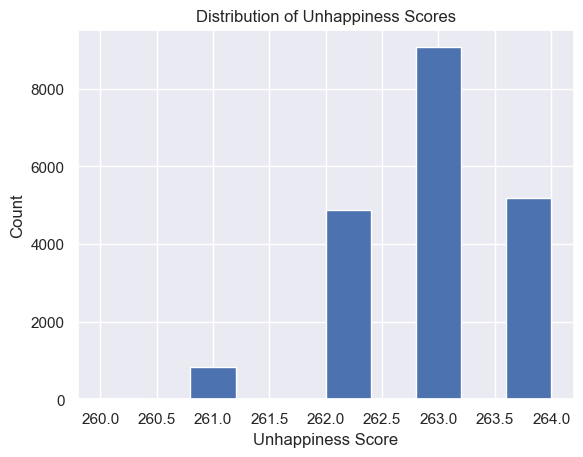

In [126]:
#Make assignments
unhappinesses = pool.find_assignments(20000)
plt.hist(unhappinesses)
plt.title("Distribution of Unhappiness Scores")
plt.xlabel("Unhappiness Score")
plt.ylabel("Count")          
plt.show()

In [128]:
#Save files 
pool.save_files(Year, Semester, sep)

In [36]:
# Generate course list spreadsheets to share with faculty


#List of column indices with relevant data to add to class lists
num_courses = len(lottery_courses)
rel_student_info = list(range(1,6))
rel_student_info.append(num_courses+12)

#For each course, put class list and waitlist on single spreadsheet
file_info = Year + sep + Year + '_' + Semester
for course in lottery_courses:
    course_filename = Year+sep+'NEUR'+course+' - '+Semester+' '+Year+' - Class List.xlsx'
    print(course_filename)
    class_list = pd.read_excel(file_info + '_classlist.xlsx', sheet_name = course) #Load class list info
    class_list = class_list.iloc[:,rel_student_info] #Remove columns with irrelevant information
    
    wait_list = pd.read_excel(file_info + '_waitlist.xlsx', sheet_name = course) #Load wait list info
    wait_list = wait_list.iloc[:,rel_student_info] #Remove columns with irrelevant information

    #--Format--
    writer = pd.ExcelWriter(course_filename,engine = 'xlsxwriter')
    class_list.to_excel(writer,startrow = 1,index=False) #Add class list
    wait_list.to_excel(writer,startrow = len(class_list)+4,index = False) #Add waitlist below class list
    
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    worksheet.set_column(0,10,20) #Set width of columns
    format_merge_title = workbook.add_format({
        'bold':True,
        'align':'center',
        'font_size':20
    })

    #Add titles to class list and waitlist sections of the spreadsheet
    worksheet.merge_range(0,0,0,5,'Class List',format_merge_title)
    worksheet.merge_range(len(class_list)+3,0,len(class_list)+3,5,'Waitlist',format_merge_title)

    writer.close()
    

2025\NEUR1440 - Fall 2025 - Class List.xlsx
2025\NEUR1930K - Fall 2025 - Class List.xlsx


,Email Address,Name,Banner ID,Concentration,Semester number,class-assignment
0,viva_voong@brown.edu,Viva Voong,B01827544,Neuroscience,7,1930K
1,adam_ibrahim@brown.edu,Adam Ibrahim,B01820572,Neuroscience,7,1930K
2,phillip_meader_yetter@brown.edu,Phillip Meader Yetter,B01785023,Neuroscience,7,1930K
3,jedidiah_kim@brown.edu,Jedidiah Kim,B01630330,Neuroscience,7,1930K
4,ziyuan_wang@brown.edu,Ziyuan Wang,B01786814,Neuroscience,7,1930K
